![example](images/home_reno.jpg)

## Home Renovation Analysis 


* Author: Angela Loyola
* Student pace: Self-Paced
* Instructor name: Mark Barbour

## Overview & Business Problem

As a real estate company, many clients approach our firm seeking advice on how to increase the value of their existing homes through renovations before selling. This project aims to address this question and determine which types of home renovations can lift the estimated value of a property and providing our stakeholders with a quantifiable measure of that increase. 

By employing an iterative approach to construct a regression model, with price as the dependent variable, the final model will  identify the different influential factors that exhibit a strong correlation with home prices. 

Utilizing KC Housing Database, I will focus soley on variables that are feasible to renovate, such as bathrooms or heat source, while excluding data points like "Waterfront". By carefully selecting the variables to be tested, I will ensure that the resulting model generates actionable insights for our stakeholders.

## Data Understanding & Exploration

In [1]:
### Importing all packages and libaries 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv('data/kc_house_data.csv') #Loading KC data Set

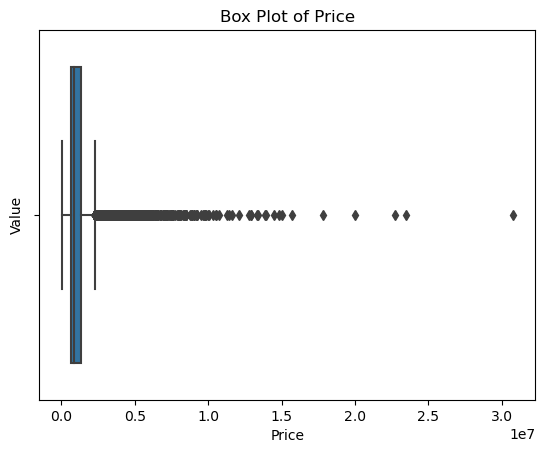

In [62]:
import seaborn as sns

# Variable I want to Visualize
variable = 'price'

# Create the box plot
sns.boxplot(data=df, x=variable)

plt.xlabel('Price')
plt.ylabel('Value')
plt.title('Box Plot of Price')

# Display
plt.show()

In [3]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

2. Subsetting DataFrame for columns that are feasible to renovate

In [4]:
select_cols = df[['price', 'bedrooms', 'bathrooms', 'heat_source', 'sewer_system', 'sqft_garage', 'sqft_patio', 'condition', 'sqft_living']]

3. Output description of the dataframes variables 

The description of database below shows that there are missing values in the following columns: heat_source and sewer_system. 

In [5]:
select_cols.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         30155 non-null  float64
 1   bedrooms      30155 non-null  int64  
 2   bathrooms     30155 non-null  float64
 3   heat_source   30123 non-null  object 
 4   sewer_system  30141 non-null  object 
 5   sqft_garage   30155 non-null  int64  
 6   sqft_patio    30155 non-null  int64  
 7   condition     30155 non-null  object 
 8   sqft_living   30155 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 2.1+ MB


4. Print unique values for object columns to understand the data

In [6]:
select_cols['condition'].value_counts() # This is a rating

Average      18547
Good          8054
Very Good     3259
Fair           230
Poor            65
Name: condition, dtype: int64

In [7]:
select_cols['sewer_system'].value_counts() # Most values are either Public or Private

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

In [8]:
select_cols ['heat_source'].value_counts() # Most of the data values are either Gas, Electricity, or Oil

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

## Data Cleaning & Processing

In this section, I will eliminate the null values identified during the data understanding and exploration stage from the data set. 

To address the categorical variables, I will create aggregate variables by grouping certain values that have a lower frequency. 

The categorical variables will then undergo the following processing steps: Sewer System and Heat Source will be encoded using One-Hot Encoding, while the condition column will be mapped to create a rating system.

Additionally, I will create a new variable called Solar_Power, derived from the Heat Source variable to test renewable energy in the model. 

By processing the data in this manner, I will ensure the dataset is optimized for the analysis and modeling.

In [9]:
## Drop all null values identified above 
select_cols.dropna(inplace = True)

C:\Users\AngelaLOYOLA\AppData\Local\Temp\ipykernel_24868\4006225066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_cols.dropna(inplace = True)


In [10]:
select_cols.info() ##checking that all null values have been removed 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 0 to 30154
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         30111 non-null  float64
 1   bedrooms      30111 non-null  int64  
 2   bathrooms     30111 non-null  float64
 3   heat_source   30111 non-null  object 
 4   sewer_system  30111 non-null  object 
 5   sqft_garage   30111 non-null  int64  
 6   sqft_patio    30111 non-null  int64  
 7   condition     30111 non-null  object 
 8   sqft_living   30111 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 2.3+ MB


#### Conditions Variable

In [11]:
##Converting Conditions into a rating 
rating_mapping = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
select_cols['condition_rating'] = select_cols['condition'].map(rating_mapping)

C:\Users\AngelaLOYOLA\AppData\Local\Temp\ipykernel_24868\3609746508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_cols['condition_rating'] = select_cols['condition'].map(rating_mapping)


#### Sewer System Variable

In [12]:
###For Sewer, since there is very few "Restricted" values, I will put them in public and private and make them dummy variables
select_cols['sewer_system_agg'] = np.where(select_cols['sewer_system'].str.contains('PRIVATE'), 'PRIVATE' , 'PUBLIC')

C:\Users\AngelaLOYOLA\AppData\Local\Temp\ipykernel_24868\3817159380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_cols['sewer_system_agg'] = np.where(select_cols['sewer_system'].str.contains('PRIVATE'), 'PRIVATE' , 'PUBLIC')


In [13]:
select_cols['sewer_system_agg'].value_counts() ##Checking the new values are correct

PUBLIC     25770
PRIVATE     4341
Name: sewer_system_agg, dtype: int64

In [14]:
sewer_dummies = pd.get_dummies(select_cols['sewer_system_agg'])

In [15]:
##changing column names and merging
sewer_dummies = sewer_dummies.rename(columns = {'PRIVATE': 'sewer_private', 'PUBLIC': 'sewer_public'})
select_cols = pd.concat([select_cols, sewer_dummies], axis = 1)

In [16]:
select_cols.head()

,price,bedrooms,bathrooms,heat_source,sewer_system,sqft_garage,sqft_patio,condition,sqft_living,condition_rating,sewer_system_agg,sewer_private,sewer_public
0,675000.0,4,1.0,Gas,PUBLIC,0,40,Good,1180,4,PUBLIC,0,1
1,920000.0,5,2.5,Oil,PUBLIC,0,240,Average,2770,3,PUBLIC,0,1
2,311000.0,6,2.0,Gas,PUBLIC,0,0,Average,2880,3,PUBLIC,0,1
3,775000.0,3,3.0,Gas,PUBLIC,200,270,Average,2160,3,PUBLIC,0,1
4,592500.0,2,2.0,Electricity,PUBLIC,550,30,Average,1120,3,PUBLIC,0,1


#### Heat Source Variable

In [17]:
##Since a Majorty of the heat source variables fall within Gas, Electric, or Oil, I will keep those and everything else will be other

In [18]:
select_cols['heat_source_agg'] = np.where(select_cols['heat_source'].str.contains('Solar|Other'), 'Other' , select_cols['heat_source'])

In [19]:
select_cols['heat_source_agg'].value_counts() ##checking everything worked as expected

Gas            20576
Electricity     6460
Oil             2899
Other            176
Name: heat_source_agg, dtype: int64

In [20]:
##Create dummies
heat_dummies = pd.get_dummies(select_cols['heat_source_agg'])

In [21]:
heat_dummies = heat_dummies.rename(columns = {'Electricity': 'source_electric', 'Gas': 'source_gas', 'Oil': 'source_oil', 'Other': 'source_other'})

In [22]:
select_cols = pd.concat([select_cols, heat_dummies], axis = 1)

#### Solar Power Variable

In [23]:
select_cols['solar_power'] = np.where(select_cols['heat_source'].str.contains('Solar'), 1 , 0)

In [24]:
select_cols['solar_power'].value_counts() ##Checking how many variables there are for Solar Power

0    29955
1      156
Name: solar_power, dtype: int64

In [25]:
select_cols['heat_source'].value_counts()

Gas                  20576
Electricity           6460
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [26]:
###Preview of final DB with variables to test

In [27]:
select_cols

,price,bedrooms,bathrooms,heat_source,sewer_system,sqft_garage,sqft_patio,condition,sqft_living,condition_rating,sewer_system_agg,sewer_private,sewer_public,heat_source_agg,source_electric,source_gas,source_oil,source_other,solar_power
0,675000.0,4,1.0,Gas,PUBLIC,0,40,Good,1180,4,PUBLIC,0,1,Gas,0,1,0,0,0
1,920000.0,5,2.5,Oil,PUBLIC,0,240,Average,2770,3,PUBLIC,0,1,Oil,0,0,1,0,0
2,311000.0,6,2.0,Gas,PUBLIC,0,0,Average,2880,3,PUBLIC,0,1,Gas,0,1,0,0,0
3,775000.0,3,3.0,Gas,PUBLIC,200,270,Average,2160,3,PUBLIC,0,1,Gas,0,1,0,0,0
4,592500.0,2,2.0,Electricity,PUBLIC,550,30,Average,1120,3,PUBLIC,0,1,Electricity,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,1555000.0,5,2.0,Oil,PUBLIC,0,210,Good,1910,4,PUBLIC,0,1,Oil,0,0,1,0,0
30151,1313000.0,3,2.0,Gas,PUBLIC,0,520,Average,2020,3,PUBLIC,0,1,Gas,0,1,0,0,0
30152,800000.0,3,2.0,Gas,PUBLIC,240,110,Average,1620,3,PUBLIC,0,1,Gas,0,1,0,0,0
30153,775000.0,3,2.5,Gas,PUBLIC,480,100,Average,2570,3,PUBLIC,0,1,Gas,0,1,0,0,0


In [28]:
select_cols.columns

Index(['price', 'bedrooms', 'bathrooms', 'heat_source', 'sewer_system',
       'sqft_garage', 'sqft_patio', 'condition', 'sqft_living',
       'condition_rating', 'sewer_system_agg', 'sewer_private', 'sewer_public',
       'heat_source_agg', 'source_electric', 'source_gas', 'source_oil',
       'source_other', 'solar_power'],
      dtype='object')

In [29]:
##Subset for new variables 
db = select_cols[['price', 'bedrooms', 'bathrooms',
       'sqft_garage', 'sqft_patio', 'sqft_living','condition_rating',
        'sewer_private', 'sewer_public', 
       'source_electric', 'source_gas', 'source_oil', 'source_other',
       'solar_power']]

## Correlation Test

In this step, I ran a correlation analysis to inform my descion-making process on which variable to include in the baseline model.

Using Pearson-Coefficients, Sqft_Living had the highest correlation at .60.

In [30]:
target_column = 'price'
correlations = db.corr()[target_column]

In [31]:
correlations ##Sqft_Living is the most correlated to Price

price               1.000000
bedrooms            0.288954
bathrooms           0.480337
sqft_garage         0.263674
sqft_patio          0.313789
sqft_living         0.608616
condition_rating   -0.009599
sewer_private      -0.021156
sewer_public        0.021156
source_electric    -0.116222
source_gas          0.142218
source_oil         -0.068180
source_other        0.021835
solar_power         0.022783
Name: price, dtype: float64

## Base Line Model: 

Using on the correlation coefficients outputted above, I selected the variable with the highest correlation to Price to run a baseline model.

To visually illustrate the relationship and direction between sqft_living and price, I created a scatter plot in the code block below. 

Interpretation of Scatter Plot: The scatter plot reveals a subtle positive linear relationship between sqft_living and price. As the value of sqft_living increases, the data points become more sparse. 

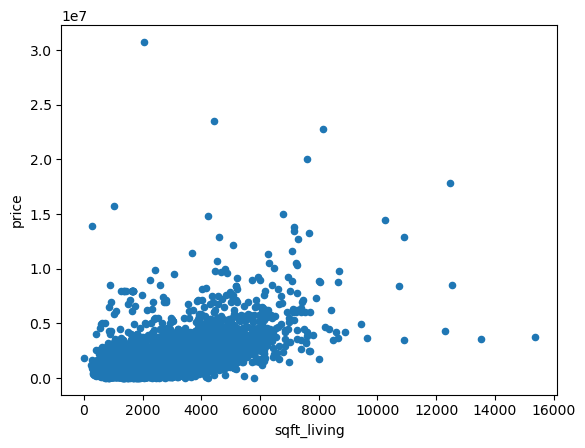

In [32]:
db.plot.scatter(x="sqft_living", y="price");

Running Baseline Model with Sqft_living as the independent test variable: 

In [33]:
y = db["price"]  # Assigning the "price" column from the dataset to the variable "y" (dependent)
X_baseline = db["sqft_living"]  # Assigning the "sqft_living" column from the dataset to the variable "X_baseline" (independent)

# Creating an Ordinary Least Squares (OLS) regression model with the dependent variable y and independent variable X_baseline
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))

# Fitting the OLS model to the data and obtaining the regression results
baseline_results = baseline_model.fit()

# Printing the summary of the regression results
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.771e+04
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:18:21   Log-Likelihood:            -4.4847e+05
No. Observations:               30111   AIC:                         8.969e+05
Df Residuals:                   30109   BIC:                         8.970e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.559e+04   9798.815     -7.714      

eval_env: 1


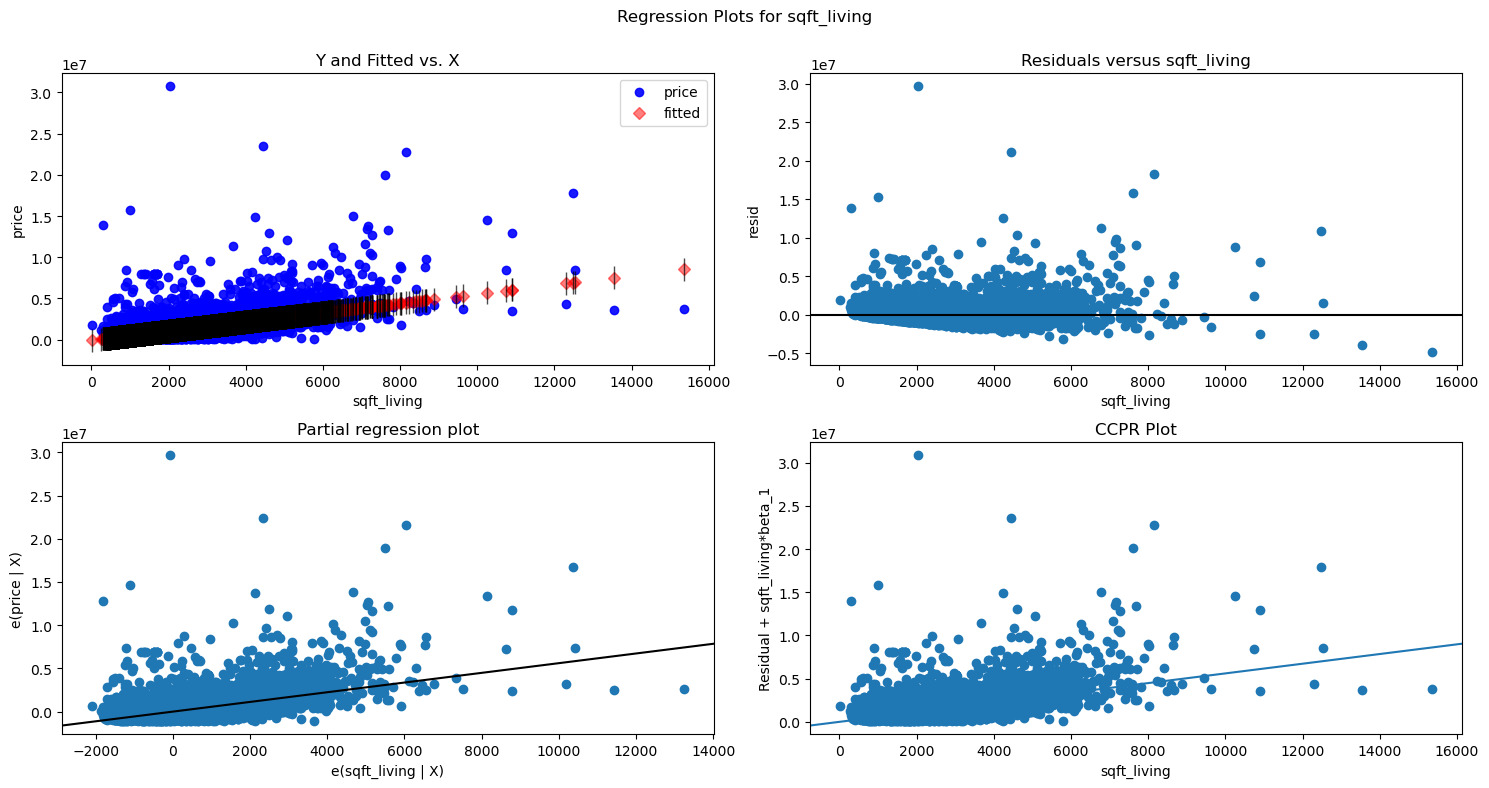

In [34]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_regress_exog(baseline_results, "sqft_living", fig=fig)
plt.show()

Baseline Model Results/Interpretation: 

<b> R-squared: </b>

The R-squared value of 0.37 indicates that approximately 37% of the variance in "Price" can be explained by "sqft_living".

<b> Coefficients:  </b>

Constant: The constant variable's coefficient is -7.559e+04. This value represents the estimated price of houses when the sqft_living variable is zero ( -$75,590).

Sqft_living: For each additional unit of sqft_living, there is an estimated increase in price by approximately $560 dollars. This suggests that larger living areas are associated with higher house prices.

In this case, both the constant term and sqft_living have p-values less than 0.05, suggesting that they are statistically significant. 

<b> F-statistic: </b> 

The F-statistic of 1.771e+04 indicates a significant relationship between sqft_living and price. The probability associated with the F-statistic is very close to zero, indicating that the model's overall fit is statistically significant.

<b> Overall and Next steps: </b>

The regression results indicate that the sqft_living variable has a statistically significant and positive relationship with the price of houses. The baseline model explains a moderate amount of the variation within price, so the next steps are to continue adding highly correlated variables to see if this can increase.  The next variable to test will be Bathrooms as it has the second highest correlation value. 

## Multi Model #1

In this model iteration, I will add Bathrooms to see if I can increase the amount of variation the model can capture.

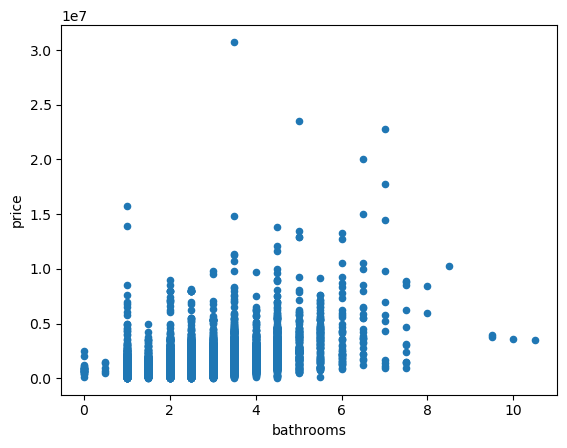

In [35]:
db.plot.scatter(x="bathrooms", y="price");

In [36]:
# Assigning the "price" column from the dataset to the variable "y"
y = db["price"]

# Creating a DataFrame "X_multi1" with columns "bathrooms" and "sqft_patio" from the dataset
X_multi1 = db[["bathrooms", 'sqft_living']]

# Creating an Ordinary Least Squares (OLS) regression model with the dependent variable y and independent variables X_multi1
multi_model1 = sm.OLS(y, sm.add_constant(X_multi1))

# Fitting the OLS model to the data and obtaining the regression results
multi_results1 = multi_model1.fit()

# Printing the summary of the regression results
print(multi_results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     8867.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:18:26   Log-Likelihood:            -4.4846e+05
No. Observations:               30111   AIC:                         8.969e+05
Df Residuals:                   30108   BIC:                         8.970e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.749e+04   1.16e+04     -8.429      

Multi Model #1 Results and Interpretation: 

<b> R-squared: </b> 

The R-squared value of 0.371 indicates that approximately 37.1% of the variance in "Price" can be explained by "Bathrooms" and "sqft_living". This suggests that these two variables together have a slighly greater ability to explain the variation in price (+.1%) than the baseline model. 

<b> Coefficients: </b> 

The constant term is -9.749e+04, indicating the estimated price when all independent variables are zero is -$97,490.

The coefficient for the "bathrooms" variable is 2.587e+04. This means that, on average, for every additional bathroom, the estimated price increases by $25,870.

The coefficient for the "sqft_living" variable is 542.2820. On average, for every additional square foot of living space, the estimated price increases by $542, assuming all other variables are held constant. This is slightly lower than the coeffficient in the baseline model. 

<b> F-statistic: </b>

The F-statistic is 8867 and the corresponding p-value is 0.00. This indicates that the overall model is statistically significant.

<b> Overall and Next Steps: </b>

The model suggests that the number of bathrooms and the square footage of living space have significant effects on the price of a property. However, the model's overall explanatory power is still moderate with the R-Squared remaining around 37%. In the next step, I will add the next highly correlated variable: sqft_patio. 

## Multi Model #2

As the regression above is statistically significant, but I will test in other variables to try to capture more of the variance. 

In [37]:
# Assigning Price from the dataset to the variable "y"
y = db["price"]

# Creating a DataFrame "X_multi2" with multiple columns from the dataset
X_multi2 = db[["bathrooms", "sqft_patio",'sqft_living']]

# Creating an Ordinary Least Squares (OLS) regression model with the dependent variable y and independent variables X_multi2
multi_model2 = sm.OLS(y, sm.add_constant(X_multi2))

# Fitting the OLS model to the data and obtaining the regression results
multi_results2 = multi_model2.fit()

# Printing the summary of the regression results
print(multi_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     6068.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:18:26   Log-Likelihood:            -4.4831e+05
No. Observations:               30111   AIC:                         8.966e+05
Df Residuals:                   30107   BIC:                         8.967e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.551e+04   1.15e+04     -8.298      

Multi Model #2 Results/Interpretation: 

<b> R-squared: </b>

The R-squared value is 0.377 which indicates that approximately 37.7% of the variability in the "price" can be explained by the model. This is a +.6% increase from the Multi Model #1 results, suggesting that the inclusion sqft_patio did help explain more of the variance of the model. 

<b> F-statistic: </b> 

The F-statistic value of 6068 indicates a significant overall relationship and the low p-value further supports the statistical significance of the model.

<b> Coefficients: </b>

The constant term remains negative at -9.551e+04. 

The coefficient for the 'bathrooms' variable is 2.122e+04, indicating that each additional bathroom is associated with an estimated increase in price of approximately $21,220. This is lower than in the Multi Model #1 results. 

The coefficient for the 'sqft_living' variable is 514.3610, suggesting that a one-unit increase in the square footage of the living space is associated with an estimated increase in price of approximately $514.36. This value is lower than the previous 2 model iterations but still roughly in line. 

The coefficient for the 'sqft_patio' variable is 312.2198, indicating that a one-unit increase in the square footage of the patio is associated with an estimated increase in price of approximately $312.22.

Overall, the the model results explain slightly more variance than Multi Model 1 and it is still statistically significant. However, the interpretability of a negative constant remains uncertain.

## Multi Model #3 

In this iteration, I will incorporate the variables from the previous model along with all the heat source variables to determine which ones should remain in the final model.

In [38]:
# Assign the dependent variable 'price' from the DataFrame to the variable 'y'
y = db["price"]

# Assign the selected independent variables to the DataFrame 'X_multi3'
X_multi3 = db[["bathrooms", "sqft_patio", "sqft_living", "source_electric", "source_oil", "source_gas", "source_other", "solar_power"]]

# Create an OLS (Ordinary Least Squares) model with the dependent variable 'y' and independent variables in 'X_multi3'
multi_model3 = sm.OLS(y, sm.add_constant(X_multi3))

# Fit the OLS model to the data and obtain the results
multi_results3 = multi_model3.fit()

# Print the summary of the regression results
print(multi_results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     2610.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:18:26   Log-Likelihood:            -4.4829e+05
No. Observations:               30111   AIC:                         8.966e+05
Df Residuals:                   30103   BIC:                         8.967e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -5.292e+04   3.28e+04     

Multi Model #3 Results/Interpretations


<b> R-squared: </b> 

The R-squared value of 0.378 indicates that approximately 37.8% of the variation in price can be explained by the model. This is .1% greater than the Multi Model #2 results indicating that adding more variables to the model helped only slightly in the explanatory power of the model. 

<b> F-statistic </b> 

The F-statistic of  2610 indicates that there is a significant relationship between the independent variables as a whole and the dependent variable. 

<b> Coefficients: </b> 

Constant: The coefficient is -5.292e+04 ($-52,920) with a p-value of 0.106. This means that the constant term is not statistically significant.

Bathrooms: The coefficient is 3.091e+04 ($30,910) with a low p-value. This indicates that the number of bathrooms has a statistically significant positive relationship with the price.This value is larger than observed in previous model iterations. 

Sqft_patio: The coefficient is 312.6320 with a low p-value. This suggests that the square footage of the patio has a statistically significant positive relationship with the price. An increase in the patio's square footage is associated with an increase in the price of $312.63. This is in line with previous model iterations. 

Sqft_living: The coefficient is 512.6268 with a low p-value. This indicates that the square footage of the living area has a statistically significant positive relationship with the price. An increase in the living area's square footage is associated with an increase in the price of $512.63. This is in line with previous model iterations. 

Source_electric: The coefficient is -5.824e+04 ($-58,240) with a p-value of 0.074. This implies that the source of electricity has a statistically insignificant negative relationship with the price. A property with an electric power source is associated with a decrease in the price compared to other power sources.

Source_oil: The coefficient is 1.474e+04 ($14,740) with a p-value of 0.659. This suggests that the source of oil does not have a statistically significant relationship with the price. 

Source_gas: The coefficient is -7.447e+04 ($-74,470) with a p-value of 0.021. This implies that the source of gas has a statistically significant negative relationship with the price. A property with a gas power source is associated with a decrease in the price.

Source_other: The coefficient is 6.504e+04 ($65,040) with a p-value of 0.607. This suggests that the "other" power source category does not have a statistically significant relationship with the price.

Solar_power: The coefficient is -9.65e+03 ($-9,650) with a p-value of 0.954. This implies that solar power does not have a statistically significant relationship with the price. The coefficient is negative, but the p-value is relatively high, indicating that the relationship is not significant. 

<b> Overall and Next Steps: </b>

The regression results indicate that only bathrooms, sqft_patio, sqft_living, and source_gas have statistically significant relationships with the price of houses. Therefore, going forward, I will drop the source variables that were insiginficant from the model and test an iteration only using the significant variables. 

## Multi Model #4 

In this model iteration, I've only kept source_gas in the model to see the results. 

In [39]:
# Assign the dependent variable 'price' from the DataFrame to the variable 'y'
y = db["price"]

# Assign the selected independent variables to the DataFrame 'X_multi3'
X_multi4 = db[["bathrooms", "sqft_patio", "sqft_living", "source_gas"]]

# Create an OLS (Ordinary Least Squares) model with the dependent variable 'y' and independent variables in 'X_multi3'
multi_model4 = sm.OLS(y, sm.add_constant(X_multi4))

# Fit the OLS model to the data and obtain the results
multi_results4 = multi_model4.fit()

# Print the summary of the regression results
print(multi_results4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     4559.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:18:26   Log-Likelihood:            -4.4831e+05
No. Observations:               30111   AIC:                         8.966e+05
Df Residuals:                   30106   BIC:                         8.967e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.188e+04   1.19e+04     -6.868      

Multi Model #4 Results/Interpretation: 

<b> R-squared: </b> 

The R-squared value of 0.377 indicates that approximately 37.7% of the variation in price can be explained by the variables in the model. This means that even removing the insignificant source varriables returned the R-Sqaured to it value in Multi Model #2 - before the source variables were added in. 

Therefore, while the coefficients and p-values of source_gas are signficant, I will not include it going forward in the model because it is not producing a better interpretation of the variation. 

## Multi Model #5

To further enhance the model's read on the variability in price, the next variable to be evaluated is Sewer System.

In [40]:
# Assign the dependent variable 'price' from the DataFrame to the variable 'y'
y = db["price"]

# Assign the selected independent variables to the DataFrame 'X_multi3'
X_multi5 = db[["bathrooms", "sqft_patio", "sqft_living" ,"sewer_public", "sewer_private"]]

# Create an OLS (Ordinary Least Squares) model with the dependent variable 'y' and independent variables in 'X_multi3'
multi_model5 = sm.OLS(y, sm.add_constant(X_multi5))

# Fit the OLS model to the data and obtain the results
multi_results5 = multi_model5.fit()

# Print the summary of the regression results
print(multi_results5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     4653.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:18:26   Log-Likelihood:            -4.4819e+05
No. Observations:               30111   AIC:                         8.964e+05
Df Residuals:                   30106   BIC:                         8.964e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.058e+05   8084.094    -13.083

Multi Model #5 Results/Interpretation: 

<b> R-squared: </b> 

The R-squared value of 0.382 indicates that approximately 38.2% of the variation in the price can be explained by the independent variables included in the model. This is +.5% percentage points greater than Multi Model 2. 

<b> F-Statistic: </b>

The F-statistic is 4653, and the associated p-value is 0.00.This suggests that the overall model has a statistically significant relationship with Price. 

<b> Overall and Next Steps: </b>

By introducing the variable "sewer_system" into the model, the bathrooms variable became statistically insignificant. However, from a practical standpoint, it doesn't seem logical to prioritize the inclusion of sewere system over the bathrooms variable. Therefore, in future iterations of the model it is reasonable to retain the bathrooms variable in the model for a more meaningful analysis.

Therefore, while the coefficients and p-values of the added variables regarding the sewer system is signficant, I will not include it going forward in the model. 

## Multi Model #6

Next, I will include Condition Rating in the analysis to assess its impact and determine its significance in predicting Price.

In [41]:
# Assign the dependent variable 'price' from the DataFrame to the variable 'y'
y = db["price"]

# Assign the selected independent variables to the DataFrame 'X_multi3'
X_multi6 = db[["bathrooms", "sqft_patio", "sqft_living" ,"condition_rating"]]

# Create an OLS (Ordinary Least Squares) model with the dependent variable 'y' and independent variables in 'X_multi3'
multi_model6 = sm.OLS(y, sm.add_constant(X_multi6))

# Fit the OLS model to the data and obtain the results
multi_results6 = multi_model6.fit()

# Print the summary of the regression results
print(multi_results6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     4558.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:18:26   Log-Likelihood:            -4.4831e+05
No. Observations:               30111   AIC:                         8.966e+05
Df Residuals:                   30106   BIC:                         8.967e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.843e+05   2.39e+04  

Multi Model #6 Results/Interpretation: 

<b> R-squared: </b> 

The R-squared value of 0.377 indicates that approximately 37.7% of the variation in price can be explained by the independent variables included in the model. This result is consistent with Multi Model #2. 

Therefore, despite not contributing to an improvement in the R-squared value, the inclusion of condition ratings in the model remains justified. This is because condition ratings exhibit statistical significance and their inclusion does not affect the adjusted R-squared when compared to Multi_Model 2.

## Final Model Selection 

After conducting 6 model iterations, excluding the baseline model, I have chosen Multi-Model 6 as the final model for this analysis. In the following code block, I have provided partial regression plots for each variable included in the model, and I will explain my reasoning behind this selection.

The partial regression plots show the relationship between each variable and the dependent variable. By examining the plots, I can observe the strongest positive relationship continues to be sqft_living. 

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


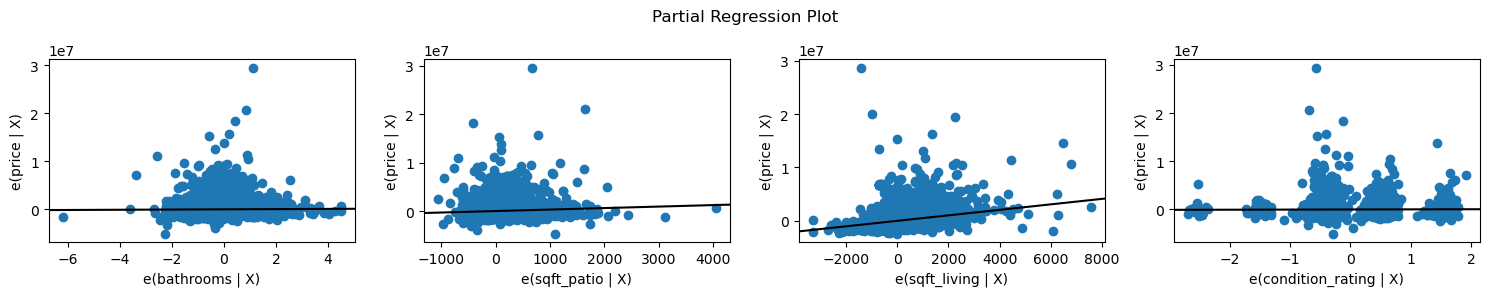

In [42]:
fig = plt.figure(figsize=(15,5))
sm.graphics.plot_partregress_grid(
    multi_results6,
    exog_idx=list(X_multi6.columns),
    grid=(2,4),
    fig=fig)
plt.tight_layout()
plt.show()

<b> Selection Reasoning: <b> 

I selected the above model based on the statistical significance of both the model and the individual variables. Each variable in the model has a coefficient that is interpretable, and their low p-values indicate a high level of confidence in their statistical significance.

The F-statistic of 4558 and its very low p-value provide strong evidence that the model as a whole is statistically significant. This suggests that the included variables collectively have a strong relationship with the price.

These are the shortcomings of the previous models:

1. In Model 3, multiple heat source variables were found to be statistically insignificant. This implies that including these variables did not contribute significantly to explaining the price.

2. Model 4 attempted to address the issue by including only the statistically significant heat source variables. However, this resulted in the model's R-squared not improving from previous model iterations at all. 

3. In Model 5, the inclusion of sewer system variables came at the expense of the bathrooms variable, which seemed counterintuitive from a business standpoint. Additionally, the increase in the R-squared was only marginal.

Therefore, the final model was chosen over the previous iterations because it included only variables that were statistically significant (identified in iteration 1, 2 and 6) and contributed to the overall model's read on the variation of Price. Therefore, this model provides the most comprehensive view on the factors of a home the impact the overall value. 


## Recommendations & Conclusions


Based on the regression results, here are four recommendations for homeowners looking to increase the value of their homes through renovations before selling:

1. <b> Focus on bathroom renovations: </b> Consider adding an additional bathroom or upgrading existing bathrooms to attract potential buyers and potentially increase the value of your home. However, it's important to carefully assess the cost-benefit ratio of such renovations to ensure they align with your budget and market expectations. According to the regression results, the coefficient for bathrooms is 2.246e+04. This suggests that, on average, each additional bathroom in a home is associated with an incremental increase in price of approximately $22,460. 

2. <b> Enhance the outdoor living space: </b>  Consider expanding or improving your outdoor living space to create an attractive and functional area for potential buyers. This could involve adding a patio, deck, or outdoor seating area, and landscaping to create a visually appealing environment. The coefficient patio sqft. is 306.8388. This implies that for every additional square foot of patio space, we can expect an incremental increase in price of approximately $307. 

3. <b> Invest in the living area: </b> If feasible, explore options for expanding the living space, such as adding an extension, converting a basement or attic into usable living space, or removing non-load-bearing walls to create an open floor plan. These enhancements can provide buyers with more living space and potentially increase the desirability and value of your home. The coefficient of living sqft variable is 515.0090. This suggests that for every additional square foot of living space, we can expect an incremental increase in price of approximately $515.

4. <b> Improve the condition of the property: </b> Prioritize making necessary repairs and upgrades throughout the property, including fixing any structural issues, updating outdated features, refreshing paint and finishes, and ensuring that the home is well-maintained. Creating a move-in ready and well-cared-for property can attract buyers and potentially increase the perceived value.The coefficient for condition rating is 2.468e+04. This indicates that each increase in the property condition rating is associated with an incremental increase in price of approximately $24,680. 


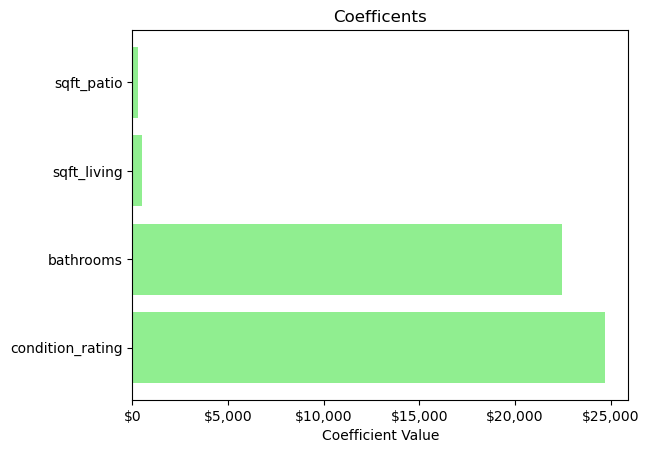

In [70]:
# Extract coefficients and feature names from regression results
coefficients = multi_results6.params[1:]  # Exclude the intercept term
features = X_multi6.columns

# Sort coefficients and features by absolute value in descending order
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_features = features[sorted_indices]

# Choose Colors
positive_color = 'lightgreen'
negative_color = 'red'

# graph
fig, ax = plt.subplots()

ax.set_yticks(np.arange(len(sorted_features)))
ax.set_yticklabels(sorted_features)

# Format x-axis tick labels as dollars
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Plot the coefficients as horizontal bars
ax.barh(np.arange(len(sorted_features)), sorted_coefficients, color=[positive_color if c >= 0 else negative_color for c in sorted_coefficients])

# Add a vertical line at zero
ax.axvline(x=0, color='black', linewidth=0.5)

# Set labels and title
ax.set_xlabel('Coefficient Value')
ax.set_title('Coefficents')

# Display the graph
plt.show()

## Limitations and Next Steps

The above analysis was done on a dataset that didn't include one of the most influential aspects of home prices: Location. 

Therefore, for future analyses, it is strongly recommended to obtain a more expansive dataset that encompasses location information. This would allow for a more comprehensive examination of the relationships between various predictors and price, ultimately leading to more reliable and insightful results.